In [1]:
# Step 0. Load libraries and custom modules
# Basic input/output
import pickle
import urllib
import tarfile
# Matrices and dataframes
import numpy as np
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# Data pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# Clustering
from sklearn.cluster import KMeans
# Metrics
from sklearn.metrics import silhouette_score, adjusted_rand_score

In [2]:
# Step 1. Load data and prepare
# Information: These data contain gene expression values from a 
# manuscript authored by The Cancer Genome Atlas (TCGA) Pan-Cancer 
# analysis project investigators.
# There are 881 samples (rows) representing five distinct cancer 
# subtypes. Each sample has gene expression values for 
# 20,531 genes (columns). The dataset is available from the 
# UC Irvine Machine Learning Repository

# The labels are strings containing abbreviations of cancer types:
# BRCA: Breast invasive carcinoma
# COAD: Colon adenocarcinoma
# KIRC: Kidney renal clear cell carcinoma
# LUAD: Lung adenocarcinoma
# PRAD: Prostate adenocarcinoma

# 1.1 Manual download (About 200MB)
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
# archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"
# # Build the url
# full_download_url = urllib.parse.urljoin(url, archive_name)

# # Download the file
# r = urllib.request.urlretrieve (full_download_url, archive_name)

# # Extract the data from the archive
# tar = tarfile.open(archive_name, "r:gz")
# tar.extractall()
# tar.close()
# 1.2 Assume you have this on a data folder
df_raw_data = pd.read_csv('../Data/Raw/TCGA_data.csv')
df_raw_labels = pd.read_csv('../Data/Raw/TCGA_labels.csv')

In [3]:
# 1.2 Let's get the basic info
df_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [4]:
# 1.3 Let's see a sample of the data
df_raw_data.sample(10)

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
698,sample_698,0.807767,1.909965,2.857523,6.486339,8.882395,0.0,7.339636,0.000000,0.000000,...,6.297806,8.328451,10.161724,2.358284,10.034318,11.927059,10.504233,9.646334,6.175816,0.000000
306,sample_306,0.000000,3.339779,2.658988,6.646887,9.203221,0.0,8.128670,1.234992,0.000000,...,6.518913,9.465109,10.604516,5.596419,9.960707,11.475971,10.064056,9.157210,5.141433,0.000000
52,sample_52,0.000000,2.396708,2.399062,6.343800,11.105666,0.0,8.188876,0.000000,0.000000,...,5.187594,7.855473,10.039988,8.250862,9.400258,11.295321,10.698835,9.350163,3.317261,0.000000
208,sample_208,0.000000,1.256286,2.155684,6.898692,9.994891,0.0,7.849955,0.489235,0.000000,...,4.929370,8.641929,9.352719,6.721947,10.154147,13.197991,10.320067,9.413768,8.076142,0.000000
85,sample_85,0.000000,4.393910,5.578099,6.304062,9.335779,0.0,7.994659,0.471031,0.000000,...,6.099455,8.889836,10.173740,6.863492,9.724811,11.775779,10.652388,9.644963,7.692037,0.471031
636,sample_636,0.000000,3.206846,4.462661,6.800046,9.766019,0.0,8.674249,0.982656,0.000000,...,5.942920,8.684552,9.629572,5.457719,9.275747,11.670939,10.518250,9.209502,7.120145,0.000000
134,sample_134,0.000000,3.004340,2.366700,6.672256,9.927494,0.0,7.515361,0.000000,0.000000,...,5.751116,8.875335,10.283366,7.830889,8.985520,10.816144,10.210964,9.349281,2.682888,0.000000
218,sample_218,0.000000,4.466366,5.244050,6.407003,9.045315,0.0,7.854600,0.699285,0.000000,...,5.578256,8.565909,10.148731,4.876679,10.032404,12.081220,10.264806,9.632488,5.971456,0.000000
418,sample_418,0.000000,2.375623,2.739589,6.493261,10.229011,0.0,5.926203,0.676358,0.377401,...,4.802912,8.486457,9.826070,8.400973,10.113039,11.129431,9.414725,11.067461,4.374121,0.000000
526,sample_526,0.000000,2.463492,3.442293,6.850874,9.415991,0.0,7.270968,0.000000,0.000000,...,6.622088,9.022593,10.219907,2.886277,10.212630,11.027982,10.388082,9.968667,7.738680,0.000000


In [5]:
# 1.4 Now let's see the labels info
df_raw_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [6]:
# 1.5 Show a sample of the labels
df_raw_labels.sample(6)

,Unnamed: 0,Class
278,sample_278,KIRC
659,sample_659,LUAD
261,sample_261,COAD
380,sample_380,KIRC
691,sample_691,LUAD
59,sample_59,BRCA


In [16]:
# Step 2. Transform data 
# 2.1 Drop unused columns
df_interim_data = df_raw_data.drop(df_raw_data.columns[0], axis=1)
df_interim_labels = df_raw_labels.drop(df_raw_labels.columns[0], axis=1)
# 2.2 Concatenate dataframes
df_interim = pd.concat([df_interim_data, df_interim_labels], axis=1)

In [17]:
# Step 3. Perform EDA
# 3.1 Describe the data
df_interim.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


In [35]:
# Step 4. Cluster the data
# 4.1 Separate the data
X = df_interim.drop(['Class'], axis=1)
y = df_interim[['Class']]
no_clusters = y['Class'].nunique()

# 4.2 Create a preprocessing pipeline
preprocessor = Pipeline([
    ('scaler', MinMaxScaler()),
    ('PCA', PCA(n_components=2, random_state=123))
])

# 4.3 Create a clusterer pipeline
clusterer = Pipeline([
    ('kmeans', KMeans(n_clusters=no_clusters, 
                      init='k-means++', 
                      random_state=123))
])

# 4.4 Join the preprocessing and clusterer into a pipe
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clusterer', clusterer)
])

# 4.5 Fit the data into the pipe
pipe.fit(X)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('PCA',
                                  PCA(n_components=2, random_state=123))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(n_clusters=5, random_state=123))]))])

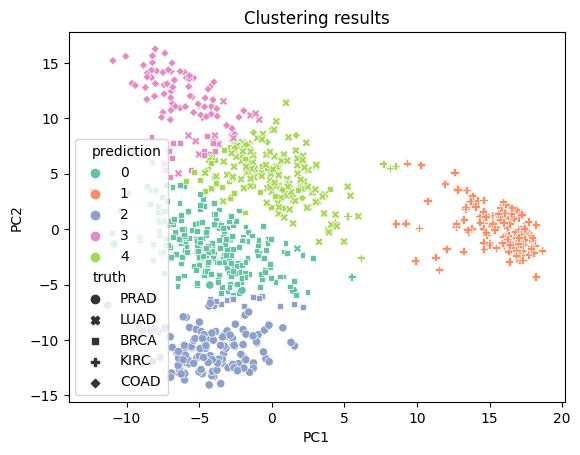

In [38]:
# 4.6 Create a dataframe placeholder
df = pd.DataFrame(pipe['preprocessor'].transform(X), 
                  columns=['PC1','PC2'])
df['prediction'] = pipe['clusterer']['kmeans'].labels_
df['truth'] = y

# 4.7 Compare the results using a plot
plot = sns.scatterplot(x='PC1', 
                       y='PC2', 
                       data=df, 
                       hue='prediction', 
                       style='truth',
                       palette= 'Set2')
plot.set_title('Clustering results')
plt.show()

In [46]:
# 4.8 Calculate Silhouette Score
preproc_data = pipe['preprocessor'].transform(X)
s_score = silhouette_score(preproc_data, df['prediction'])
print(f'The silhouette score is {s_score:.3f}')

The silhouette score is 0.512
